In [109]:
import sys
import os
sys.path.insert(0, os.path.expanduser('~/covid19_spread'))
import pandas
import plotly.express as px
import sqlite3
from forecast_db import DB
import yaml
from datetime import timedelta
from IPython.display import SVG, display
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
conn_ = sqlite3.connect(DB)
conn = sqlite3.connect(':memory:')
conn_.backup(conn)

In [96]:
loc_map = {
    'new-jersey': 'New Jersey',
    'nystate': 'New York'
}

In [97]:
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_06_11_09_05/forecasts/forecast_best_mae.csv'

forecast_pth = os.environ.get('FORECAST_PTH', forecast_pth)

cfg = yaml.safe_load(open(os.path.dirname(forecast_pth) + '/../cfg.yml'))
df = pandas.read_csv(forecast_pth, index_col='date', parse_dates=['date'])
df = df.reset_index().melt(id_vars=['date'], value_name='counts', var_name='loc3')
df['loc2'] = loc_map[cfg['region']]
df['id'] = 'this_forecast'
df['forecast_date'] = (df['date'].min() - timedelta(days=1)).date()
df.to_sql('infections', conn, if_exists='append', index=False)
basedate = (df['date'].min() - timedelta(days=1)).date()

In [111]:
dates = ', '.join([f"'{d}'" for d in df['date'].dt.date.unique()])
q = f"""
SELECT loc2, loc3, date, id, counts, forecast_date
FROM infections
WHERE loc3 IS NOT NULL 
    AND loc2 = '{loc_map[cfg['region']]}' 
    AND date >= '{basedate - timedelta(days=7)}'
    AND forecast_date >= '{basedate - timedelta(days=7)}' 
    AND forecast_date <= '{basedate}' 
"""
forecasts = pandas.read_sql(q, conn, parse_dates=['date', 'forecast_date'])
forecasts['forecast_date'] = forecasts['forecast_date'].dt.date
ref = pandas.read_sql("SELECT * FROM infections WHERE id='nyt_ground_truth'", conn, parse_dates=['date', 'forecast_date'])


In [99]:
grouped = forecasts.groupby(['loc2', 'id', 'forecast_date', 'date']).sum().reset_index()
grouped['color'] = grouped['id'] + '_' + grouped['forecast_date'].apply(str)

# Forecast Trajectories

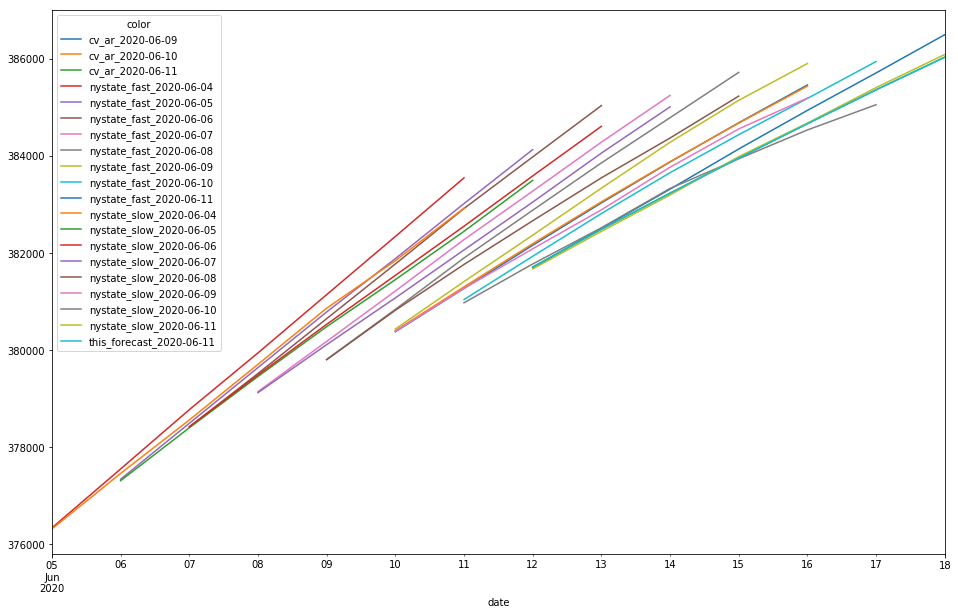

In [100]:
fig = grouped.pivot(index='date', columns='color', values='counts').plot(figsize=(16, 10))

# Mean Absolute Error

In [113]:
merged = forecasts.merge(ref, on=['loc2', 'loc3', 'date'], suffixes=('_forecast', '_gt'))
merged['diff'] = (merged['counts_forecast'] - merged['counts_gt']).abs()
mae = merged.groupby(['forecast_date_forecast', 'id_forecast'])['diff'].mean().reset_index()
mae = mae.rename(columns={'forecast_date_forecast': 'forecast_date', 'id_forecast': 'model_id', 'diff': 'mae'})
display(mae.sort_values(by=['forecast_date', 'model_id']))

,forecast_date,model_id,mae
0,2020-06-04,nystate_fast,23.587558
1,2020-06-04,nystate_slow,19.766129
2,2020-06-05,nystate_fast,24.339862
3,2020-06-05,nystate_slow,19.209677
4,2020-06-06,nystate_fast,25.729263
5,2020-06-06,nystate_slow,22.006912
6,2020-06-07,nystate_fast,21.099078
7,2020-06-07,nystate_slow,18.786866
8,2020-06-08,nystate_fast,16.944892
9,2020-06-08,nystate_slow,14.704301
